In [1]:
import numpy as np
from scipy.stats import multivariate_normal, chi2, norm, beta
import random
import copy
from scipy.special import logsumexp
from scipy.spatial.distance import pdist, squareform
from random import shuffle, sample
import os
import sys
import matplotlib.pyplot as plt
from visualisation import plot_feature_space
import os
import scipy.io
from pyvbmc import VBMC
import glob


# Add the folder functions to the system path
sys.path.append(os.path.abspath('../agents'))
sys.path.append(os.path.abspath('../stimuli'))

# Now you can import the function from get_content.py
from GMM_WM import GMMWM_Agent
from stim_utils import generate_test, generate_training_interleaved, generate_training_blocked, load_mat


In [2]:
def config_dict():
    counter = 0
    conf = {}
    label = {}
    for r in range(1, 7):
        for l in range(1, 7):
            counter += 1
            conf[counter] = [r, l]
            label[counter] = int(abs(r - l) <= 1)
    return [conf, label]
            

def read_mat_files(conf, base_dir='../Results'):
    data = {}
    for N in range(1, 97):
        folder_name = f'sbj{N}'
        folder_path = os.path.join(base_dir, folder_name)
        training_pattern = os.path.join(folder_path, f'sbj{N}Training*')
        test_pattern     = os.path.join(folder_path, f'sbj{N}Test*')
        
        training_files = glob.glob(training_pattern)
        test_files     = glob.glob(test_pattern)
        if training_files and test_files:
            training_file = training_files[0]
            test_file = test_files[0]
            training_data = scipy.io.loadmat(training_file)
            test_data = scipy.io.loadmat(test_file)
            data[N] = {
                'training' : {
                    'trialN' : [training_data['Results'][0][0][0][0][i][0][0][0] for i in range(training_data['Results'][0][0][0][0].shape[0])],
                    'stimuli' :[conf[0][training_data['Results'][0][0][0][0][i][1][0][0]] for i in range(training_data['Results'][0][0][0][0].shape[0])],
                    'label' : [conf[1][training_data['Results'][0][0][0][0][i][1][0][0]] for i in range(training_data['Results'][0][0][0][0].shape[0])],
                    'outcome' : [training_data['Results'][0][0][0][0][i][2][0][0] for i in range(training_data['Results'][0][0][0][0].shape[0])], 
                    'action' : [training_data['Results'][0][0][0][0][i][4][0][0] for i in range(training_data['Results'][0][0][0][0].shape[0])],
                    'trialLost' : [training_data['Results'][0][0][0][0][i][6][0][0] for i in range(training_data['Results'][0][0][0][0].shape[0])]
                },
                'test' : {
                    'trialN' : [test_data['Results'][0][0][0][0][i][0][0][0] for i in range(test_data['Results'][0][0][0][0].shape[0])],
                    'stimuli' :[conf[0][test_data['Results'][0][0][0][0][i][1][0][0]] for i in range(test_data['Results'][0][0][0][0].shape[0])],
                    'label' :[conf[1][test_data['Results'][0][0][0][0][i][1][0][0]] for i in range(test_data['Results'][0][0][0][0].shape[0])],
                    'outcome' : [test_data['Results'][0][0][0][0][i][2][0][0] for i in range(test_data['Results'][0][0][0][0].shape[0])], 
                    'action' : [test_data['Results'][0][0][0][0][i][4][0][0] for i in range(test_data['Results'][0][0][0][0].shape[0])],
                    'trialLost' : [test_data['Results'][0][0][0][0][i][6][0][0] for i in range(test_data['Results'][0][0][0][0].shape[0])]
                }
            }
            #data[N] = {'training': training_data, 'test': test_data}
        else:
            print(f"Files for {folder_name} not found in {base_dir}.")
    return data


In [3]:
conf = config_dict()
data = read_mat_files(conf)

Files for sbj61 not found in ../Results.
Files for sbj62 not found in ../Results.
Files for sbj63 not found in ../Results.
Files for sbj64 not found in ../Results.
Files for sbj65 not found in ../Results.
Files for sbj66 not found in ../Results.
Files for sbj67 not found in ../Results.
Files for sbj68 not found in ../Results.
Files for sbj73 not found in ../Results.


In [ ]:
# def grid_search(n_train = 5, n_test = 7, order = 'interleaved', stimuli = None):

#     if order == 'interleaved' and stimuli == None:
#         X_train, y_train = generate_training_interleaved(n_train)
#     elif stimuli == None:
#         X_train, y_train = generate_training_blocked(n_train)
#     else:
#         X_train, y_train = stimuli

#     X_test, y_test = generate_test(n_test)

#     accuracy = 0
#     for t in np.arange(0.2, 1, 0.1):
#         for s in np.arange(0.4, 4, 0.2):
#             agent = GMMWM_Agent(tot_memory = 7, 
#                     threshold = t, 
#                     sigma0 = s, 
#                     decay = 0, 
#                     phi = 0.3, 
#                     start_p = 1, 
#                     lr = 0.2,
#                     switch = True)
#             try:
#                 action_probs = agent(X_train, y_train)
#                 action_probs = agent(X_test, y_test, feedback = False)

#                 if np.sum(agent.reward_test)/len(agent.reward_test) > accuracy and len(agent.mu) <= 10:
#                     accuracy = np.sum(agent.reward_test)/len(agent.reward_test)
#                     print('New record:')
#                     print('Accuracy =', accuracy)
#                     print('Threshold =', t)
#                     print('Sigma zero =', s)
#                     print('N. of clusters:', len(agent.mu))
#                     print('Final reliance on clusters:', agent.phi)
#             except:
#                 print('error')
#                 print('Threshold =', t)
#                 print('Sigma zero =', s)



In [4]:
class LJ:
    def __init__(self, data, config): #memory, min_lifetime, min_weight, fluid, pruning, criterion):

        # self.agent_config = {
        #     'Total memory' : memory,
        #     'Minimum cluster lifetime' : min_lifetime,
        #     'Minimum cluster weight' : min_weight,
        #     'Fluid strategy' : fluid,
        #     'Pruning strategy' : {
        #         'name' : pruning, # can be 'merging' or 'erasing'
        #         'criterion' : criterion # for 'merging' it can be 'KLD', 'euclidean distance' or 'mahalanobis distance', for 'erasing' it can be 'smallest' or 'oldest'
        #     }
        # }
        self.agent_config = config

        self.data = data
        self.eps = 1e-8

    def loglik(self, x):

        self.agent_config['Sigma0'] = x

        # self.agent_config['Threshold'] = x[1]
        
        # self.agent_config['Cluster strategy weight'] = x[2]
        # self.agent_config['Initial uncertainty'] = 1

        # if self.agent_config['Fluid strategy']:        
        #     self.agent_config['Strategy learning rate'] = x[3]
        #     self.agent_config['strategy bias'] = x[4]
        # else:
        #     self.agent_config['Strategy learning rate'] = 0.1
        #     self.agent_config['strategy bias'] = 1



        X_train = self.data['training']['stimuli']
        y_train = self.data['training']['label']
        X_test = self.data['test']['stimuli']
        y_test = self.data['test']['label']

        agent = GMMWM_Agent(self.agent_config)
        p_train = agent(X_train, y_train, feedback = True)
        #print('Training complete')
        p_test = agent(X_test, y_test, feedback = False)

        ll = 0
        for l, m, t in zip(self.data['training']['trialLost'] + self.data['test']['trialLost'], p_train + p_test, self.data['training']['action'] + self.data['test']['action']):

            if l == 1:
                t = [0.5]

            if t == 1:
                ll += np.log((0.95*m[1] + 0.1*m[0]) + self.eps)
            elif t == 0:
                ll += np.log((0.95*m[0] + 0.1*m[1]) + self.eps)
            elif t == 0.5:
                ll += np.log(0.5)

        return ll
    
    def log_prior(self, x):

        lp = 0

        lp += beta.logpdf(x[0], 1, 5)
        lp += norm.logpdf(np.log(1/x[1]), 0, 5)
        lp += beta.logpdf(x[2], 5, 1)
        #lp += norm.logpdf(np.log(x[3]), 0, 5)
        if self.agent_config['Fluid strategy']:
            lp += beta.logpdf(x[3], 9, 1)
            lp += norm.logpdf(x[4], 0, 5)

        return lp
    
    def logjoint(self, x):

        return self.log_prior(x) + self.loglik(x)



        



In [6]:
agent_config = {
    'Total memory' : 5,
    'Threshold' : 0.9,
    'Sigma0' : 1.95,
    'Minimum cluster lifetime' : 0,
    'Minimum cluster weight' : 0.00,
    'Cluster strategy weight' : 1, # useless is Fluid strategy == False
    'Initial uncertainty' : 1, # useless is Fluid strategy == False
    'Strategy learning rate' : 0.1, # useless is Fluid strategy == False
    'strategy bias' : 1., # useless is Fluid strategy == False
    'Fluid strategy' : False,
    'Pruning strategy' : {
        'name' : 'erasing', # can be 'merging' or 'erasing'
        'criterion' : 'oldest' # for 'merging' it can be 'KLD', 'euclidean distance' or 'mahalanobis distance', for 'erasing' it can be 'smallest' or 'oldest'
    }
}

In [ ]:
# model = LJ(data = data[1], 
#            config = agent_config)

# Ns = 2**6 + 1
# ll = np.zeros((Ns))
# s_grid = np.linspace(0.1, 3, Ns)
# for i, s in enumerate(s_grid):
#     ll[i] = model.loglik(s)





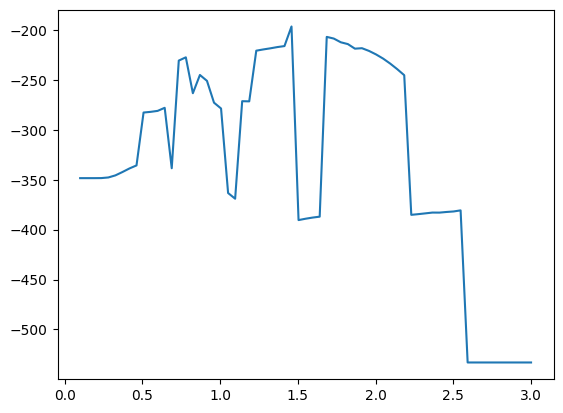

In [ ]:
# plt.plot(s_grid, ll)#np.exp(ll - np.max(ll)))

In [38]:
agent_config = {
    'Total memory' : 5,
    'Threshold' : 0.675,
    'Sigma0' : 1.95,
    'Minimum cluster lifetime' : 0,
    'Minimum cluster weight' : 0.00,
    'Cluster strategy weight' : 1, # useless is Fluid strategy == False
    'Initial uncertainty' : 1, # useless is Fluid strategy == False
    'Strategy learning rate' : 0.1, # useless is Fluid strategy == False
    'strategy bias' : 1., # useless is Fluid strategy == False
    'Fluid strategy' : False,
    'Pruning strategy' : {
        'name' : 'erasing', # can be 'merging' or 'erasing'
        'criterion' : 'smallest' # for 'merging' it can be 'KLD', 'euclidean distance' or 'mahalanobis distance', for 'erasing' it can be 'smallest' or 'oldest'
    }
}

In [28]:
# X_train, y_train = generate_training_interleaved(5)
# X_train, y_train = generate_training_blocked(5) 

# print('training data successfully generated')
# X_test, y_test = generate_test(7)

def all_sbj(data, agent_config):
    accuracy = {'model' : {'interleaved' : {}, 'blocked1' : {}, 
                           'blocked2' : {}, 'blocked3' : {}}, 
                'participants' : {'interleaved' : {}, 'blocked1' : {}, 
                                  'blocked2' : {}, 'blocked3' : {}}
                }
    for s in range(1, 121):
        if s in data.keys():
            X_train = data[s]['training']['stimuli']
            y_train = data[s]['training']['label']
            X_test = data[s]['test']['stimuli']
            y_test = data[s]['test']['label']

            agent = GMMWM_Agent(agent_config)

            p = agent(X_train, y_train, feedback = True)
            #print('Training complete')
            p = agent(X_test, y_test, feedback = False)
            # 
            # print('Test accuracy:', np.sum(agent.reward_test)/len(agent.reward_test))

            if s % 2 == 0 and s <= 60:
                group = 'blocked1'
            elif s <= 60:
                group = 'interleaved'
            elif s <=90:
                group = 'blocked2'
            else:
                group = 'blocked3'
        

            accuracy['model'][group][s] = np.round(np.sum(agent.reward_test)/len(agent.reward_test), 3)
            accuracy['participants'][group][s] = np.round(np.sum([i == j for i, j in zip(data[s]['test']['outcome'], data[s]['test']['action'])])/len(data[s]['test']['action']), 3)
                                                        
            

    return accuracy



In [29]:
model_accuracy = {}

for b in np.arange(0.1, 3.1, 0.1):
    agent_config['Threshold'] = 0.95
    agent_config['Sigma0'] = b

    # try:
    acc = all_sbj(data, agent_config)
    # except:
    #     acc = {
    #         "model" : {
    #             'blocked' : [0],
    #             'interleaved' : [0]
    #         }
    #     }
    model_accuracy[np.round(b, 2)] = acc['model']

        

In [36]:
best_accuracy = {
    'blocked1' : {s : {'par' : None, 'acc' : 0} for s in model_accuracy[0.1]['blocked1'].keys()}, 
    'interleaved' : {s : {'par' : None, 'acc' : 0} for s in model_accuracy[0.1]['interleaved'].keys()},
    'blocked2' : {s : {'par' : None, 'acc' : 0} for s in model_accuracy[0.1]['blocked2'].keys()},
    'blocked3' : {s : {'par' : None, 'acc' : 0} for s in model_accuracy[0.1]['blocked3'].keys()},
}


for par, value1 in model_accuracy.items():
    for group, value2 in value1.items():
        for s, acc in value2.items():
            if acc > best_accuracy[group][s]['acc']:
                best_accuracy[group][s]['acc'] = acc
                best_accuracy[group][s]['par'] = par
        

In [55]:
best_accuracy_global = {
    'blocked1' : {'par' : None, 'acc' : 0}, 
    'interleaved' : {'par' : None, 'acc' : 0},
    'blocked2' : {'par' : None, 'acc' : 0},
    'blocked3' : {'par' : None, 'acc' : 0},
}


for par, value1 in model_accuracy.items():
    for group, value2 in value1.items():
        acc = np.mean([value2[s] for s in value2.keys()])
        if acc > best_accuracy_global[group]['acc']:
            best_accuracy_global[group]['acc'] = acc
            best_accuracy_global[group]['par'] = par

In [56]:
best_accuracy_global

{'blocked1': {'par': np.float64(0.5), 'acc': np.float64(0.7037333333333335)},
 'interleaved': {'par': np.float64(1.2), 'acc': np.float64(0.749266666666667)},
 'blocked2': {'par': np.float64(0.6), 'acc': np.float64(0.7024761904761905)},
 'blocked3': {'par': np.float64(1.8), 'acc': np.float64(0.6435)}}

In [38]:
interleaved_s = list(best_accuracy['interleaved'].keys())
blocked1_s = list(best_accuracy['blocked1'].keys())
blocked2_s = list(best_accuracy['blocked2'].keys())
blocked3_s = list(best_accuracy['blocked3'].keys())

In [39]:
for_analysis = {group : {'par' : [], 'acc' : []} for group in best_accuracy.keys()}

for group in for_analysis.keys():
    for_analysis[group]['acc'] = [best_accuracy[group][s]['acc'] for s in best_accuracy[group].keys()]
    for_analysis[group]['par'] = [best_accuracy[group][s]['par'] for s in best_accuracy[group].keys()]

In [43]:
for group in for_analysis.keys():
    print(f"{group} average accuracy: {np.mean(for_analysis[group]['acc'])}")
    print(f"{group} median sigma0: {np.median(for_analysis[group]['par'])}")

blocked1 average accuracy: 0.7666333333333334
blocked1 median sigma0: 0.9
interleaved average accuracy: 0.8122000000000001
interleaved median sigma0: 1.05
blocked2 average accuracy: 0.7776666666666666
blocked2 median sigma0: 2.3
blocked3 average accuracy: 0.7498333333333332
blocked3 median sigma0: 1.55


In [75]:
import json

# Load from JSON file
with open('model_results-5oldest.json', 'r') as json_file:
    model_accuracy = json.load(json_file)



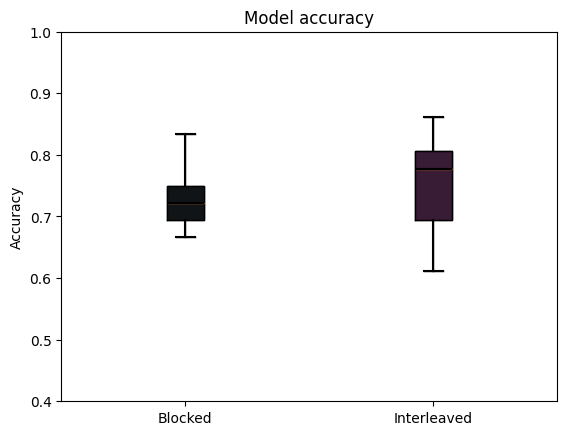

In [82]:
toplot = [model_accuracy[best_accuracy['blocked']['par']]['blocked'], model_accuracy[best_accuracy['interleaved']['par']]['interleaved']]


# Create the boxplot
plt.boxplot(toplot)

bp = plt.boxplot(toplot, patch_artist=True)


# Set colors for each box
colors = [(16/255, 20/255, 22/255), (56/255, 27/255, 52/255)]  # First box blue, second box red
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Optionally, set colors for other elements like whiskers, caps, medians, etc.
for whisker in bp['whiskers']:
    whisker.set(color='black', linewidth=1.5)
for cap in bp['caps']:
    cap.set(color='black', linewidth=1.5)
for median in bp['medians']:
    median.set(color='black', linewidth=1.5)
for flier in bp['fliers']:
    flier.set(marker='o', color='black', alpha=0.5)


# Set the x-axis labels
plt.xticks([1, 2], ['Blocked', 'Interleaved'])

plt.ylim([0.4, 1])

# Add labels and title
plt.ylabel('Accuracy')
plt.title('Model accuracy')

# Display the plot
plt.show()

In [16]:
# print('Accuracy of the model, (interleaved):', np.mean(accuracy['model']['interleaved']))
# print('Accuracy of the model, (blocked):', np.mean(accuracy['model']['blocked']))
# print('Accuracy of the participants, (interleaved):', np.mean(accuracy['participants']['interleaved']))
# print('Accuracy of the participants, (blocked):', np.mean(accuracy['participants']['blocked']))

In [83]:
import numpy as np
from scipy import stats

# Replace these lists with your actual data
list1 = toplot[1]
list2 = toplot[0]

# Convert lists to NumPy arrays
data1 = np.array(list1)
data2 = np.array(list2)

# Define significance level
alpha = 0.05

# Test for normality
stat1, p1 = stats.shapiro(data1)
stat2, p2 = stats.shapiro(data2)
print(f"Shapiro-Wilk test for list1: W={stat1:.4f}, p-value={p1:.4f}")
print(f"Shapiro-Wilk test for list2: W={stat2:.4f}, p-value={p2:.4f}")

if p1 > alpha and p2 > alpha:
    print("Both datasets are normally distributed.")
    # Check if data is paired
    if len(data1) == len(data2):
        # Paired t-test
        t_stat, t_p = stats.ttest_rel(data1, data2)
        print(f"Paired t-test: t-statistic={t_stat:.4f}, p-value={t_p:.4f}")
    else:
        # Independent t-test
        t_stat, t_p = stats.ttest_ind(data1, data2)
        print(f"Independent t-test: t-statistic={t_stat:.4f}, p-value={t_p:.4f}")
else:
    print("At least one dataset is not normally distributed.")
    # Check if data is paired
    if len(data1) == len(data2):
        # Wilcoxon signed-rank test
        w_stat, w_p = stats.wilcoxon(data1, data2)
        print(f"Wilcoxon signed-rank test: statistic={w_stat:.4f}, p-value={w_p:.4f}")
    else:
        # Mann-Whitney U test
        u_stat, u_p = stats.mannwhitneyu(data1, data2)
        print(f"Mann-Whitney U test: U-statistic={u_stat:.4f}, p-value={u_p:.4f}")

# Interpret the result
if (p1 > alpha and p2 > alpha and t_p < alpha) or (p1 <= alpha or p2 <= alpha and w_p < alpha):
    print("The difference between the two lists is statistically significant.")
else:
    print("The difference between the two lists is not statistically significant.")


Shapiro-Wilk test for list1: W=0.8471, p-value=0.0060
Shapiro-Wilk test for list2: W=0.9038, p-value=0.0669
At least one dataset is not normally distributed.
Mann-Whitney U test: U-statistic=225.0000, p-value=0.0966
The difference between the two lists is statistically significant.


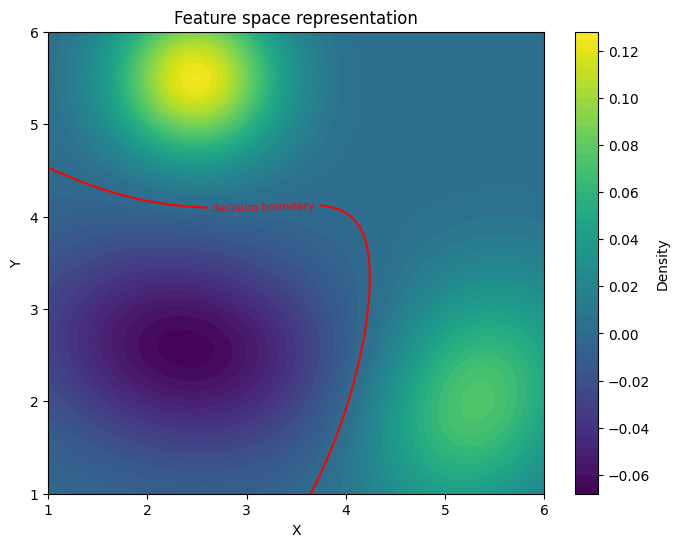

In [ ]:
agent_config = {
    'Total memory' : 5,
    'Threshold' : 0.95,
    'Sigma0' : 1.8,
    'Minimum cluster lifetime' : 0,
    'Minimum cluster weight' : 0.00,
    'Cluster strategy weight' : 1, # useless is Fluid strategy == False
    'Initial uncertainty' : 1, # useless is Fluid strategy == False
    'Strategy learning rate' : 0.1, # useless is Fluid strategy == False
    'strategy bias' : 1., # useless is Fluid strategy == False
    'Fluid strategy' : False,
    'Pruning strategy' : {
        'name' : 'erasing', # can be 'merging' or 'erasing'
        'criterion' : 'oldest' # for 'merging' it can be 'KLD', 'euclidean distance' or 'mahalanobis distance', for 'erasing' it can be 'smallest' or 'oldest'
    }
}

def single_subject_sim(data, s, agent_config):#
    X_train = data[s]['training']['stimuli']
    y_train = data[s]['training']['label']
    X_test = data[s]['test']['stimuli']
    y_test = data[s]['test']['label']

    agent = GMMWM_Agent(agent_config)

    p = agent(X_train, y_train, feedback = True)
    #print('Training complete')
    p = agent(X_test, y_test, feedback = False)

    return agent

mega_agent = single_subject_sim(data, 1, agent_config)
mega_agent.mu = []
mega_agent.Sigma = []
mega_agent.label = []
mega_agent.alpha = []
for s in blocked3_s:
    agent = single_subject_sim(data, s, agent_config)
    mega_agent.mu += list(agent.mu)
    mega_agent.Sigma += list(agent.Sigma)
    mega_agent.label += list(agent.label)
    mega_agent.alpha += list(agent.alpha)

if agent.switch:
    plt.plot(agent.phis)
    plt.ylim([0, 1.05])

plot_feature_space(mega_agent)

In [73]:
# See the statistics of each cluster
for c in range(len(agent.label)):
    print('Cluster ' + str(c+1) + ':')
    print('Label:', agent.label[c])
    print('Weight:', agent.alpha[c])
    print('Mean:', agent.mu[c])
    print('Covariance matrix:')
    print(agent.Sigma[c])
    print('--------------')

Cluster 1:
Label: 1
Weight: 10.0
Mean: [2. 3.]
Covariance matrix:
[[0.004 0.   ]
 [0.    0.004]]
--------------
Cluster 2:
Label: 1
Weight: 10.0
Mean: [5. 4.]
Covariance matrix:
[[0.004 0.   ]
 [0.    0.004]]
--------------
Cluster 3:
Label: 1
Weight: 10.0
Mean: [2. 2.]
Covariance matrix:
[[0.004 0.   ]
 [0.    0.004]]
--------------
Cluster 4:
Label: 0
Weight: 10.0
Mean: [1. 3.]
Covariance matrix:
[[0.004 0.   ]
 [0.    0.004]]
--------------
Cluster 5:
Label: 0
Weight: 10.0
Mean: [2. 6.]
Covariance matrix:
[[0.004 0.   ]
 [0.    0.004]]
--------------


In [30]:
import json

# Save to JSON file
with open('model_results-5oldest.json', 'w') as json_file:
    json.dump(model_accuracy, json_file, indent=4)  # indent=4 for pretty-printing
